<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number: 37
# Student 1: Jiong Li | 1533312
# Student 2: Peter Elmers | 1734350
# Student 3: P.T.C.M. Tholhuijsen | 1237447

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [168]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

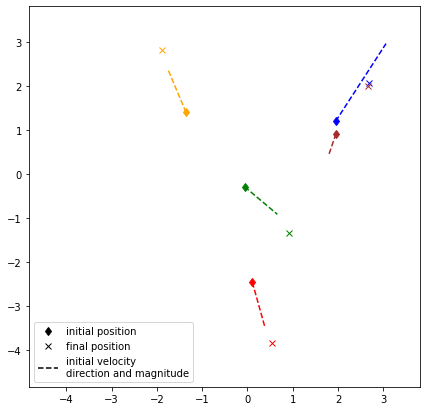

In [170]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [8]:
# Pick the best device
import torch

def try_device(device):
    # Try to put an array on given device. If successful, return device. Else, 'cpu'.
    x = torch.ones((1,))
    try:
        x.to(device)
        return device
    except:
        return 'cpu'

device = try_device('cuda')
if device == 'cpu':
    device = try_device('mps')

print(f'Device is set to {device}')

# Move all the little craps into torch things on the device
p_train, v_train, c_train = [torch.Tensor(vec).to(device=device) for vec in [positions_train, velocities_train, charges_train]]
p_valid, v_valid, c_valid = [torch.Tensor(vec).to(device=device) for vec in [positions_valid, velocities_valid, charges_valid]]
p_test, v_test, c_test = [torch.Tensor(vec).to(device=device) for vec in [positions_test, velocities_test, charges_test]]

Device is set to cuda


In [20]:
p_train, v_train, c_train = p_train[:2000], v_train[:2000], c_train[:2000]
p_valid, v_valid, c_valid = p_valid[:400], v_valid[:400], c_valid[:400]

In [10]:
# Create a baseline: particle position = velocity * time + initial
def baseline_predict(p0, v0, time):
    '''
    Return a numpy array of predicted x, y position of each particle in p0.
    Given p0 starting locations, v0 starting velocities, and time to predict.
    Result is computed via linear projection: v0 * time + p0.
    Where p0 and v0 are both (N x 1 x 2 x P) tensors, for N simulations, P particles/sim
    '''
    return p0 + v0 * time


In [22]:
from torch.utils.data import Dataset, DataLoader


class myDataset(Dataset):
    def __init__(self, posi, velo, charge):
        self.posi = posi
        self.velo = velo
        self.charge = charge
    
    def __len__(self):
        return len(self.posi)
    
    def __getitem__(self, index):
        i = list(zip(self.posi, self.velo, self.charge))[index]
        
        p = torch.transpose(i[0][0], 0, 1)
        v = torch.transpose(i[1][0], 0, 1)
        c = i[2]
        
        # x_p, y_p, x_v, y_v, c at t=0
        x = torch.hstack((p, v, c))
        # x.shape = [10, 5, 5]
        
        # (x_p, y_p), (x_p, y_p), (x_p, y_p) at t = 0.5, 1.0, 1.5
        y = torch.hstack((torch.transpose(i[0][1], 0, 1), 
                          torch.transpose(i[0][2], 0, 1), 
                          torch.transpose(i[0][3], 0, 1)))
        # y.shape = [10, 5, 6]
        
        return x, y


In [12]:
tmp = myDataset(p_train, v_train, c_train)
x,y = tmp.__getitem__(0)
y.shape

torch.Size([5, 6])

In [23]:
trainLoader = DataLoader(myDataset(p_train, v_train, c_train), batch_size=10)
validationLoader = DataLoader(myDataset(p_valid, v_valid, c_valid), batch_size=10)
testLoader = DataLoader(myDataset(p_test, v_test, c_test), batch_size=10)

# Model Implementation

In [14]:
import torch.nn as nn
from tqdm import tqdm

Implementation like https://github.com/higgsfield/interaction_network_pytorch/blob/master/Interaction%20Network.ipynb

In [45]:
for i in zip(p_train, v_train, c_train):
    p = torch.transpose(i[0][0], 0, 1)
    v = torch.transpose(i[1][0], 0, 1)
    c = i[2]
   
    data = torch.hstack((p, v, c))
    print(data)
    print(data[:, 0:2])
    print(data[:, 2:4])
    # x_p, y_p, x_v, y_v, c
    break

tensor(-1.9361, device='cuda:0')
tensor([[-1.9361, -0.2276, -0.7878,  0.0267, -1.0000],
        [ 3.6532, -2.7631,  1.5892, -0.4211,  1.0000],
        [-4.5496,  8.2998, -1.2906,  2.3834,  1.0000],
        [-3.0958, -3.0921, -1.9173, -0.5785,  1.0000],
        [ 0.1073, -2.8976,  0.6539, -0.5676, -1.0000]], device='cuda:0')
tensor([[-1.9361, -0.2276],
        [ 3.6532, -2.7631],
        [-4.5496,  8.2998],
        [-3.0958, -3.0921],
        [ 0.1073, -2.8976]], device='cuda:0')
tensor([[-0.7878,  0.0267],
        [ 1.5892, -0.4211],
        [-1.2906,  2.3834],
        [-1.9173, -0.5785],
        [ 0.6539, -0.5676]], device='cuda:0')


In [18]:
len(next(iter(trainLoader)))

2

In [53]:
# object-centric acceleration neural network
class AccelerationModel(nn.Module):
    def __init__(self):
        super(AccelerationModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(5, 25),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(25, 2),
        )
        
    def forward(self, x):
        x = x.view(-1, 5)
        x = self.layers(x)
        return x.view(10, 5, 2)

In [54]:
# object-centric velocity neural network
class VelocityModel(nn.Module):
    def __init__(self):
        super(VelocityModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(4, 16),
            # nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
        
    def forward(self, x):
        x = x.view(-1, 4)
        x = self.layers(x)
        return x.view(10, 5, 2)

In [55]:
# object-centric position neural network
class PositionModel(nn.Module):
    def __init__(self):
        super(PositionModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(16, 2),
        )
        
    def forward(self, x):
        x = x.view(-1, 4)
        x = self.layers(x)
        return x.view(10, 5, 2)

In [56]:
# interaction network
class InteractionNetwork(nn.Module):
    def __init__(self):
        super(InteractionNetwork, self).__init__()
        
        self.acceleration_model = AccelerationModel()
        self.velocity_model = VelocityModel()
        self.position_model = PositionModel()
        
    def forward(self, x, delta_t):
        pred_accelleration = self.acceleration_model(x)
        pred_velocity = self.velocity_model(torch.dstack((x[:, :, 2:4], torch.mul(pred_accelleration, delta_t))))
        pred_position = self.position_model(torch.dstack((x[:, :, 0:2], torch.mul(pred_velocity, delta_t))))
        return pred_position, pred_velocity
    
interaction_network = InteractionNetwork()
interaction_network.to(device=device)

InteractionNetwork(
  (acceleration_model): AccelerationModel(
    (layers): Sequential(
      (0): Linear(in_features=5, out_features=25, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=25, out_features=2, bias=True)
    )
  )
  (velocity_model): VelocityModel(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=2, bias=True)
    )
  )
  (position_model): PositionModel(
    (layers): Sequential(
      (0): Linear(in_features=4, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [57]:
def evaluation(model, test_loader, klass):
    model = model.eval()
    loss_t1, loss_t2, loss_t3, loss_tot = list(), list(), list(), list()

    with torch.no_grad():
        for x, y in test_loader:
            pred_p_t1, pred_v_t1 = model(x, 0.5)
            pred_p_t2, pred_v_t2 = model(torch.dstack((pred_p_t1, pred_v_t1, x[:, :, -1])), 0.5)
            pred_p_t3, _ = model(torch.dstack((pred_p_t2, pred_v_t2, x[:, :, -1])), 0.5)

            loss1 = criterion(pred_p_t1,y[:,:,0:2])
            loss2 = criterion(pred_p_t2,y[:,:,2:4])
            loss3 = criterion(pred_p_t3,y[:,:,4:6])

            loss_t1.append(loss1.item() / 10)
            loss_t2.append(loss2.item() / 10)
            loss_t3.append(loss3.item() / 10)

            y_pred = torch.dstack((pred_p_t1, pred_p_t2, pred_p_t3))
            loss = criterion(y_pred, y)
            loss_tot.append(loss.item() / 10)

    print(f'Average loss in totall: {round(sum(loss_tot)/len(test_loader),5)}')
    print(f'Average loss in {klass} at time= 0.5: {round(sum(loss_t1)/len(test_loader),5)}')
    print(f'Average loss in {klass} at time= 1: {round(sum(loss_t2)/len(test_loader),5)}')
    print(f'Average loss in {klass} at time= 1.5: {round(sum(loss_t3)/len(test_loader),5)}\n')

In [58]:
optimizer = torch.optim.SGD(interaction_network.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()
criterion.to(device=device)

train_loss_graph, val_loss_graph = list(), list()
for epoch in range(10):
    train_loss, val_loss = list(), list()
    
    interaction_network = interaction_network.train()
    for x_train, y_train in tqdm(trainLoader, desc="Training"):
        optimizer.zero_grad()
        pred_p_t1, pred_v_t1 = interaction_network(x_train, 0.5)
        pred_p_t2, pred_v_t2 = interaction_network(torch.dstack((pred_p_t1, pred_v_t1, x_train[:, :, -1])), 0.5)
        pred_p_t3, _ = interaction_network(torch.dstack((pred_p_t2, pred_v_t2, x_train[:, :, -1])), 0.5)
        
        y_pred = torch.dstack((pred_p_t1, pred_p_t2, pred_p_t3))
        loss = criterion(y_pred, y_train)

        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item() / 10)

    train_loss_graph.append(sum(train_loss) / len(trainLoader))
    
    interaction_network = interaction_network.eval()
    for x_val, y_val in validationLoader:
        optimizer.zero_grad()
        pred_p_t1, pred_v_t1 = interaction_network(x_val, 0.5)
        pred_p_t2, pred_v_t2 = interaction_network(torch.dstack((pred_p_t1, pred_v_t1, x_val[:, :, -1])), 0.5)
        pred_p_t3, _ = interaction_network(torch.dstack((pred_p_t2, pred_v_t2, x_val[:, :, -1])), 0.5)
        
        y_pred = torch.dstack((pred_p_t1, pred_p_t2, pred_p_t3))
        loss = criterion(y_pred, y_val)
        
        val_loss.append(loss.item() / 10)
    
    val_loss_graph.append(sum(val_loss) / len(validationLoader))
    
    #evaluation(interaction_network,validationLoader,"validation")
        
    print(f'Average loss: {round(train_loss_graph[-1],5)}')
    print(f'val loss: {round(val_loss_graph[-1],5)}\n')

test_loss = list()
interaction_network = interaction_network.eval()
for x_test, y_test in testLoader:
    optimizer.zero_grad()
    pred_p_t1, pred_v_t1 = interaction_network(x_test, 0.5)
    pred_p_t2, pred_v_t2 = interaction_network(torch.dstack((pred_p_t1, pred_v_t1, x_test[:, :, -1])), 0.5)
    pred_p_t3, _ = interaction_network(torch.dstack((pred_p_t2, pred_v_t2, x_test[:, :, -1])), 0.5)
        
    y_pred = torch.dstack((pred_p_t1, pred_p_t2, pred_p_t3))
    loss = criterion(y_pred, y_test)
        
    test_loss.append(loss.item() / 10)
    
print(f"test loss:{round(sum(test_loss) / len(testLoader),5)}")

Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 10.67it/s]


Average loss: 0.88325
val loss: 0.69019



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.22it/s]


Average loss: 0.43755
val loss: 0.09779



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.11it/s]


Average loss: 0.04922
val loss: 0.02979



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:20<00:00,  9.94it/s]


Average loss: 0.02772
val loss: 0.02676



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.37it/s]


Average loss: 0.02571
val loss: 0.02531



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.43it/s]


Average loss: 0.02436
val loss: 0.02416



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.40it/s]


Average loss: 0.02331
val loss: 0.02325



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.51it/s]


Average loss: 0.02247
val loss: 0.02252



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:19<00:00, 10.47it/s]


Average loss: 0.02181
val loss: 0.02196



Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:18<00:00, 10.56it/s]


Average loss: 0.02129
val loss: 0.02152

test loss:0.02154


In [59]:
evaluation(interaction_network,trainLoader,"training")
evaluation(interaction_network,validationLoader,"validation")
evaluation(interaction_network,testLoader,"testing")

Average loss in totall: 0.02104
Average loss in training at time= 0.5: 0.00552
Average loss in training at time= 1: 0.01865
Average loss in training at time= 1.5: 0.03895

Average loss in totall: 0.02152
Average loss in validation at time= 0.5: 0.00565
Average loss in validation at time= 1: 0.01875
Average loss in validation at time= 1.5: 0.04014

Average loss in totall: 0.02154
Average loss in testing at time= 0.5: 0.00571
Average loss in testing at time= 1: 0.01908
Average loss in testing at time= 1.5: 0.03982



In [198]:
def experiment(model, test_loader, klass):
    model = model.eval()
    loss_t1, loss_t2, loss_t3, loss_tot = list(), list(), list(), list()
    pred_positions = list()

    with torch.no_grad():
        x, y = next(iter(test_loader))
        
        pred_p, pred_v = model(x, 0.01)
        pred_positions.append(pred_p)

        for i in range(2, 151):
            pred_p, pred_v = model(torch.dstack((pred_p, pred_v, x[:, :, -1])), 0.01)
            pred_positions.append(pred_p)

        loss1 = criterion(pred_positions[49], y[:,:,0:2])
        loss2 = criterion(pred_positions[99], y[:,:,2:4])
        loss3 = criterion(pred_positions[-1], y[:,:,4:6])

        loss_t1.append(loss1.item() / 10)
        loss_t2.append(loss2.item() / 10)
        loss_t3.append(loss3.item() / 10)

        y_pred = torch.dstack((pred_positions[49], pred_positions[99], pred_positions[-1]))
        loss = criterion(y_pred, y)
        loss_tot.append(loss.item() / 10)

    print(f'Average loss in totall: {round(sum(loss_tot)/len(test_loader),5)}')
    print(f'Average loss in {klass} at time= 0.5: {round(sum(loss_t1)/len(test_loader),5)}')
    print(f'Average loss in {klass} at time= 1: {round(sum(loss_t2)/len(test_loader),5)}')
    print(f'Average loss in {klass} at time= 1.5: {round(sum(loss_t3)/len(test_loader),5)}\n')
    
    return pred_positions, x, y

In [199]:
positions, data, y = experiment(interaction_network, testLoader, "testing")

Average loss in totall: 153815749670993.9
Average loss in testing at time= 0.5: 881.41831
Average loss in testing at time= 1: 606357553.152
Average loss in testing at time= 1.5: 461446647717560.3



In [195]:
unique_pos = list()
for stamp in positions:
    unique_pos.append(stamp[0].to(device="cpu"))
    
positions = unique_pos

exp_x, exp_y = list(), list()

for frame in positions:
    exp_x.append(frame[:, 0])
    exp_y.append(frame[:, 1])

In [200]:
for frame in positions:
    print(frame)

tensor([[[ 9.7377e-01,  7.0141e-01],
         [ 1.8640e-01, -1.6075e+00],
         [-8.9542e-03, -1.9726e+00],
         [ 2.3909e+00,  3.1019e+00],
         [-3.2845e+00,  5.7759e-01]],

        [[ 1.2121e+00,  4.1136e+00],
         [-5.9152e-01, -2.4707e-02],
         [ 1.4749e+00,  1.1726e+00],
         [-2.5858e+00,  1.6356e+00],
         [ 1.4785e+00, -3.8730e+00]],

        [[-4.1141e-01,  2.8835e-01],
         [ 1.2285e+00, -1.3583e+00],
         [ 1.4902e+00, -1.2872e+00],
         [-1.6764e-01, -1.3044e+00],
         [-7.7968e-01,  1.5387e-01]],

        [[-2.9005e+00, -9.3210e-01],
         [ 3.5889e+00, -3.6187e+00],
         [-2.5588e+00, -1.2208e+00],
         [-5.4071e-01,  8.6473e+00],
         [ 7.4272e-01, -3.6201e+00]],

        [[ 1.6304e+00,  1.4002e-01],
         [-1.8745e+00, -7.0983e-01],
         [-1.6794e+00, -2.5839e+00],
         [ 1.1868e+00,  2.8477e-01],
         [-2.0703e+00, -7.4289e-01]],

        [[-4.2203e+00, -1.3347e+00],
         [ 1.9498e+00,  2.83

tensor([[[ 10.0986,   3.2297],
         [ -1.0443, -14.1334],
         [ -3.6503, -16.8776],
         [ 25.7438,  32.3188],
         [-28.2984,   5.0083]],

        [[ 14.0125,  39.0940],
         [ -5.8138,  -1.4126],
         [ 13.0006,   7.4596],
         [-21.6602,  10.2106],
         [  2.2281, -29.8905]],

        [[ -4.0148,   1.0804],
         [  9.5086,  -9.1000],
         [ 10.4426,  -8.9038],
         [ -2.1339, -12.2222],
         [ -7.1083,   0.2264]],

        [[-29.2845, -14.4782],
         [ 18.8737, -25.5958],
         [-29.3504, -16.4353],
         [ 10.2093,  79.1400],
         [ -2.9447, -28.3397]],

        [[ 14.1622,   3.1393],
         [-20.5136, -10.8124],
         [-15.2990, -21.8199],
         [ 11.2523,   2.4928],
         [-22.0980, -11.4286]],

        [[-41.5177, -20.1917],
         [ 21.7970,  27.9115],
         [ -3.4859, -17.2568],
         [ -1.8406, -11.4282],
         [ -3.6707,  14.2921]],

        [[-15.4134,   9.8275],
         [ -3.1153,  19.156

tensor([[[  85.3089,   31.8180],
         [ -48.0894, -106.8056],
         [ -69.1769, -131.5149],
         [ 285.4807,  369.1058],
         [-239.9759,   54.4639]],

        [[ 198.2036,  385.8083],
         [ -53.0434,  -23.6112],
         [  96.0022,   67.5755],
         [-180.1254,   76.9413],
         [ -72.8748, -216.8309]],

        [[ -34.2399,    8.5294],
         [  43.7322,  -64.2904],
         [  46.4128,  -61.8159],
         [ -47.7200,  -95.2342],
         [ -61.2600,    6.8383]],

        [[-320.2553, -177.6252],
         [  76.6316, -179.0853],
         [-336.7220, -194.7537],
         [ 211.8049,  777.0471],
         [-102.7339, -213.1435]],

        [[ 121.7452,   36.2982],
         [-230.0090, -130.3898],
         [-179.9251, -165.8191],
         [  97.3140,   28.4536],
         [-246.1176, -138.6814]],

        [[-450.1514, -248.2684],
         [ 244.8753,  316.7318],
         [ -69.8686, -133.9812],
         [ -43.7318,  -88.7835],
         [  -2.8178,  126.0091]],

tensor([[[  593.5457,   292.5126],
         [ -465.4845,  -760.9771],
         [ -600.9771,  -948.4123],
         [ 2835.3845,  3683.9102],
         [-1800.2561,   477.0569]],

        [[ 2572.2593,  3483.8630],
         [ -487.0317,  -258.6887],
         [  687.5400,   498.0789],
         [-1333.0598,   540.1400],
         [ -878.5478, -1512.0181]],

        [[ -256.7875,    70.8122],
         [  150.9645,  -401.2770],
         [  176.8416,  -385.0675],
         [ -427.9418,  -684.5372],
         [ -463.3333,    84.9547]],

        [[-3178.7585, -1827.7944],
         [   91.7190, -1127.3485],
         [-3396.9861, -1982.2576],
         [ 2379.6750,  6752.7178],
         [ -949.4113, -1523.8907]],

        [[  882.9058,   352.2455],
         [-2300.8057, -1333.2655],
         [-1700.1604, -1538.2406],
         [  707.8634,   276.5544],
         [-2456.6338, -1420.4484]],

        [[-4457.6260, -2558.6848],
         [ 2434.1848,  3162.5886],
         [ -609.9937,  -964.3085],
         [

tensor([[[   5347.2246,    3722.7581],
         [  -5554.9023,   -7760.6665],
         [  -7511.5049,   -9476.3994],
         [  42338.4570,   55061.4102],
         [ -19199.6426,    5677.1851]],

        [[  39577.6562,   51540.5547],
         [  -7120.0078,   -4053.0046],
         [   7102.0742,    5156.9326],
         [ -14062.9688,    5469.1699],
         [ -10458.9658,  -15496.1562]],

        [[  -2737.2563,     827.7449],
         [   -159.6827,   -3506.4285],
         [    172.9275,   -3347.7996],
         [  -5207.8809,   -6915.6626],
         [  -4973.2183,    1211.4580]],

        [[ -48081.1680,  -28042.7598],
         [  -3913.2620,  -10106.6016],
         [ -51726.0508,  -30300.6973],
         [  47835.8984,   86370.1484],
         [ -11532.4443,  -15396.9736]],

        [[   8377.7227,    4752.9404],
         [ -34897.8164,  -20394.9492],
         [ -23696.6699,  -21432.3848],
         [   6748.8135,    3737.5608],
         [ -37255.3633,  -21762.8613]],

        [[ -674

tensor([[[   48170.6211,    34952.2227],
         [  -75432.3438,   -68579.9844],
         [ -101793.4297,   -92111.3125],
         [  553134.4375,   719196.4375],
         [ -181356.4062,    57295.8672]],

        [[  517643.7500,   673323.3125],
         [  -93524.8984,   -54297.8984],
         [   65253.8008,    47396.5820],
         [ -132019.7031,    49982.3086],
         [ -137035.6719,  -129098.4922]],

        [[  -25867.9277,     8267.8867],
         [  -13644.2373,   -28820.6562],
         [  -10633.6992,   -26941.5703],
         [  -70793.5859,   -64122.1953],
         [  -47184.1055,    13229.7637]],

        [[ -638174.5625,  -373528.6250],
         [  -54637.4648,   -89603.1016],
         [ -688331.4375,  -403693.7812],
         [  784143.6250,  1038137.1875],
         [ -157136.5156,  -142345.7812]],

        [[   69095.3281,    49635.9805],
         [ -463679.9688,  -271531.2500],
         [ -289351.6562,  -261660.4219],
         [   55258.1211,    39573.1758],
        

tensor([[[ 4.4320e+05,  3.2187e+05],
         [-9.2341e+05, -8.3509e+05],
         [-1.2441e+06, -1.1250e+06],
         [ 7.2248e+06,  9.3944e+06],
         [-1.7117e+06,  5.6266e+05]],

        [[ 6.7615e+06,  8.7930e+06],
         [-1.2398e+06, -7.2479e+05],
         [ 6.0037e+05,  4.3605e+05],
         [-1.2407e+06,  4.6136e+05],
         [-1.6990e+06, -1.5363e+06]],

        [[-2.4405e+05,  8.0900e+04],
         [-1.6357e+05, -2.5914e+05],
         [-1.4629e+05, -2.3918e+05],
         [-8.6514e+05, -7.8243e+05],
         [-4.4677e+05,  1.3644e+05]],

        [[-8.4835e+06, -4.9739e+06],
         [-5.7340e+05, -8.1456e+05],
         [-9.1581e+06, -5.3703e+06],
         [ 1.0367e+07,  1.3491e+07],
         [-1.9207e+06, -1.7371e+06]],

        [[ 6.3335e+05,  4.5995e+05],
         [-6.1731e+06, -3.6194e+06],
         [-3.5383e+06, -3.2001e+06],
         [ 5.0526e+05,  3.6679e+05],
         [-6.5876e+06, -3.8613e+06]],

        [[-1.1902e+07, -6.9802e+06],
         [ 6.2061e+06,  8.07

tensor([[[ 3.6264e+06,  2.6338e+06],
         [-9.8937e+06, -8.9475e+06],
         [-1.3330e+07, -1.2055e+07],
         [ 8.2403e+07,  1.0718e+08],
         [-1.4337e+07,  4.8283e+06]],

        [[ 7.7192e+07,  1.0036e+08],
         [-1.4385e+07, -8.4251e+06],
         [ 4.9156e+06,  3.5696e+06],
         [-1.0358e+07,  3.8073e+06],
         [-1.8210e+07, -1.6472e+07]],

        [[-2.0443e+06,  6.9396e+05],
         [-1.5549e+06, -2.0754e+06],
         [-1.3511e+06, -1.9371e+06],
         [-9.2593e+06, -8.3731e+06],
         [-3.7480e+06,  1.2055e+06]],

        [[-9.8559e+07, -5.7808e+07],
         [-6.7648e+06, -6.1971e+06],
         [-1.0641e+08, -6.2448e+07],
         [ 1.1836e+08,  1.5392e+08],
         [-2.0565e+07, -1.8599e+07]],

        [[ 5.1905e+06,  3.7702e+06],
         [-7.1715e+07, -4.2073e+07],
         [-3.7865e+07, -3.4249e+07],
         [ 4.1428e+06,  3.0090e+06],
         [-7.6485e+07, -4.4826e+07]],

        [[-1.3832e+08, -8.1177e+07],
         [ 7.0801e+07,  9.20

tensor([[[ 2.3524e+07,  1.7083e+07],
         [-8.1339e+07, -7.3558e+07],
         [-1.0960e+08, -9.9111e+07],
         [ 7.1696e+08,  9.3248e+08],
         [-9.4843e+07,  3.2448e+07]],

        [[ 6.7141e+08,  8.7323e+08],
         [-1.2708e+08, -7.4501e+07],
         [ 3.1875e+07,  2.3154e+07],
         [-6.8379e+07,  2.4928e+07],
         [-1.4984e+08, -1.3554e+08]],

        [[-1.3518e+07,  4.6599e+06],
         [-1.4238e+07, -1.2952e+07],
         [-1.2105e+07, -1.1410e+07],
         [-7.6263e+07, -6.8968e+07],
         [-2.4802e+07,  8.2179e+06]],

        [[-8.7151e+08, -5.1118e+08],
         [-5.5858e+07, -5.0523e+07],
         [-9.4163e+08, -5.5257e+08],
         [ 1.0308e+09,  1.3400e+09],
         [-1.6914e+08, -1.5298e+08]],

        [[ 3.3631e+07,  2.4420e+07],
         [-6.3409e+08, -3.7189e+08],
         [-3.1154e+08, -2.8174e+08],
         [ 2.6828e+07,  1.9483e+07],
         [-6.7562e+08, -3.9590e+08]],

        [[-1.2243e+09, -7.1841e+08],
         [ 6.1640e+08,  8.01

In [197]:
for x_x, y_y in zip(exp_x, exp_y):
    print(x_x, y_y)
    

tensor([ 0.9738,  0.1864, -0.0090,  2.3909, -3.2845]) tensor([ 0.7014, -1.6075, -1.9726,  3.1019,  0.5776])
tensor([ 4.4902, -5.5335, -0.8940, -2.6309, -0.7945]) tensor([ 0.5128, -3.5719, -2.7409,  4.3906,  1.5472])
tensor([ 4.4902, -5.5335, -0.8940, -2.6309, -0.7945]) tensor([ 0.5128, -3.5719, -2.7409,  4.3906,  1.5472])
tensor([ 4.4902, -5.5335, -0.8940, -2.6309, -0.7945]) tensor([ 0.5128, -3.5719, -2.7409,  4.3906,  1.5472])
tensor([ 4.4902, -5.5335, -0.8940, -2.6309, -0.7945]) tensor([ 0.5128, -3.5719, -2.7409,  4.3906,  1.5472])
tensor([ 4.4902, -5.5335, -0.8940, -2.6309, -0.7945]) tensor([ 0.5128, -3.5719, -2.7409,  4.3906,  1.5472])
tensor([ 4.4902, -5.5335, -0.8940, -2.6309, -0.7945]) tensor([ 0.5128, -3.5719, -2.7409,  4.3906,  1.5472])
tensor([ 4.4902, -5.5335, -0.8940, -2.6309, -0.7945]) tensor([ 0.5128, -3.5719, -2.7409,  4.3906,  1.5472])
tensor([ 4.4902, -5.5335, -0.8940, -2.6309, -0.7945]) tensor([ 0.5128, -3.5719, -2.7409,  4.3906,  1.5472])
tensor([ 4.4902, -5.5335, -0

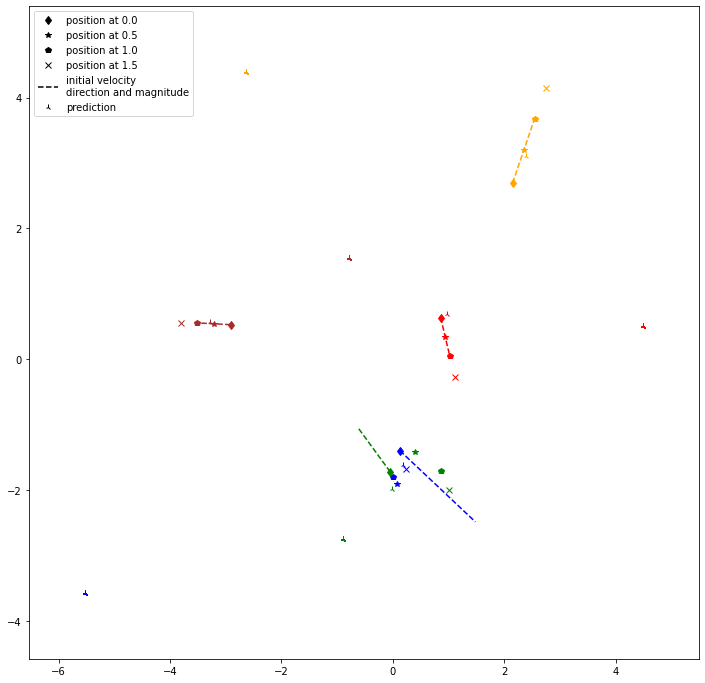

In [196]:
data = data[0].to(device="cpu")
y = y[0].to(device="cpu")

fig = plt.figure()
axes = plt.gca()
axes.set_xlim([-5., 5.])
axes.set_ylim([-5., 5.])
colors = ['red', 'blue', 'green', 'orange', 'brown']
all_x, all_y = list(), list()

for i in range(len(data)):
    plt.plot(data[i][0], data[i][1], 'd', color=colors[i])
    plt.plot(y[i][0], y[i][1], '*', color=colors[i])
    plt.plot(y[i][2], y[i][3], 'p', color=colors[i])
    plt.plot(y[i][4], y[i][5], 'x', color=colors[i])
    plt.plot([data[i][0], data[i][0] + data[i][2]], [data[i][1], data[i][1] + data[i][3]], '--', color=colors[i])
    
    x_pos, y_pos = list(), list()
    for x_x, y_y in zip(exp_x, exp_y):
        x_pos.append(x_x[i])
        y_pos.append(y_y[i])
                    
    all_x.append(x_pos)
    all_y.append(y_pos)
    plt.plot(x_pos, y_pos, '2', color=colors[i])

fig.set_size_inches(12, 12)
plt.xlim(np.min(all_x)-1, np.max(all_x) +1)
plt.ylim(np.min(all_y)-1, np.max(all_y) +1)
plt.plot([], [], 'd', color='black', label='position at 0.0')
plt.plot([], [], '*', color='black', label='position at 0.5')
plt.plot([], [], 'p', color='black', label='position at 1.0')
plt.plot([], [], 'x', color='black', label='position at 1.5')
plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
plt.plot([], [], '2', color='black', label='prediction')
plt.legend()

plt.show()


In [26]:
import torch.nn as nn

# Evaluate the baseline model (what metrics? r2? rms?)
def rms(p_pred, p_actual):
    '''
    Return the root mean squared distance between predicted locations and actual locations.
    Where p_pred and p_actual are both (N x T x 2 x P) tensors.
    '''
    mse = nn.MSELoss()
    return mse(p_pred, p_actual).sqrt().item()

def baseline_evaluate(p, v, time):
    '''
    Evaluate the baseline "model" at given time in {0, 0.5, 1, 1.5}.
    '''
    p_pred = baseline_predict(p[:, :1, :, :], v, time)
    idx = int(time / 0.5)
    p_actual = p[:, idx:idx+1, :, :]
    # Currently just rms, but we could add more evaluations
    return {'rms': rms(p_pred, p_actual)}

print('Baseline error should be 0:', baseline_evaluate(p_train, v_train, 0))

# Print some more metrics
for klass in ['train', 'valid', 'test']:
    p_klass, v_klass = locals()[f'p_{klass}'], locals()[f'v_{klass}']
    print(f'Error over time should increase ({klass}).')
    for t in [0.5, 1, 1.5]:
        print(f't = {t}', baseline_evaluate(p_train, v_train, t))

Baseline error should be 0: {'rms': 0.0}
Error over time should increase (train).
t = 0.5 {'rms': 0.24874936044216156}
t = 1 {'rms': 0.5171805024147034}
t = 1.5 {'rms': 0.7905893325805664}
Error over time should increase (valid).
t = 0.5 {'rms': 0.24874936044216156}
t = 1 {'rms': 0.5171805024147034}
t = 1.5 {'rms': 0.7905893325805664}
Error over time should increase (test).
t = 0.5 {'rms': 0.24874936044216156}
t = 1 {'rms': 0.5171805024147034}
t = 1.5 {'rms': 0.7905893325805664}


Text(0, 0.5, 'loss value')

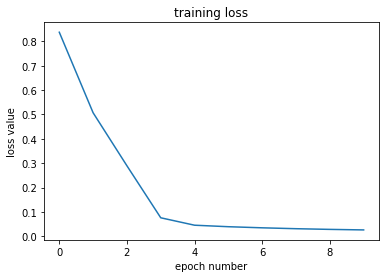

In [27]:
import matplotlib.pyplot as plt

plt.plot(train_loss_graph)
plt.title("training loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")

Text(0, 0.5, 'loss value')

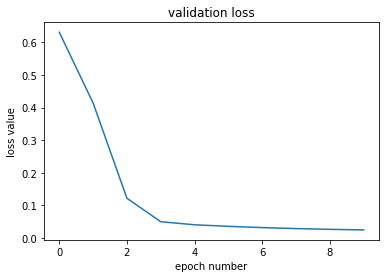

In [28]:
plt.plot(val_loss_graph)
plt.title("validation loss")
plt.xlabel("epoch number")
plt.ylabel("loss value")

# RNN doesn't work below

In [ ]:
# For sample i at time t:
# p = p' + delta_t * (v' + a * delta_t)
# trainLoader = DataLoader(myDataset(p_train, v_train, c_train), batch_size=10)
# validationLoader = DataLoader(myDataset(p_valid, v_valid, c_valid), batch_size=10)
# testLoader = DataLoader(myDataset(p_test, v_test, c_test), batch_size=10)
# x = (p,v,c), y = (p_1,p_2,p_3)

In [70]:
# RNN model

input_size = 5
hidden_size = 10
num_layers = 3

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        # self.hidden_size = hidden_size
        # self.num_layers = num_layers
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # self.fc = nn.Linear(hidden_size, 1)
        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True,
        )
        self.out = nn.Linear(hidden_size,1)
    
    def forward(self, x, h_state):
        # # Set initial hidden and cell states 
        # h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # # Forward propagate LSTM
        # out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # # Decode the hidden state of the last time step
        # out = self.fc(out[:, -1, :])
        # return out
        r_out, h_state = self.rnn(x, h_state)
        outs = []
        for time_step in range(r_out.size(1)):
            outs.append(self.out(r_out[:,time_step,:]))
        return torch.stack(outs,dim=1), h_state


rnn_model = RNN()
rnn_model.to(device=device)
# interaction_network = InteractionNetwork()
# interaction_network.to(device=device)

RNN(
  (rnn): RNN(5, 10, num_layers=3, batch_first=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)

In [74]:
start = 0
end = 1.5
time_step = 0.01
h_state = None
num_epoch = 3
learning_rate = 0.001

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)

train_loss_graph, val_loss_graph = list(), list()

# Train the model
for epoch in range(num_epoch):
    train_loss, val_loss = list(), list()
    
    rnn_model = rnn_model.train()
    for x_train, y_train in tqdm(trainLoader, desc="Training"):
        
        #steps = np.linspace(start, end, time_step, dtype=np.float32,endpoint=False)
        y_pred, h_state = rnn_model(x_train,h_state)

        print(y_pred)
        loss = criterion(y_pred, y_train[2])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item() / num_epoch)
    
    train_loss_graph.append(sum(train_loss) / len(trainLoader))
        
    rnn_model = rnn_model.eval()
    for x_val, y_val in validationLoader:
        y_pred_val, h_state = rnn_model(x_val,h_state)
        loss = criterion(y_pred_val, y_val)
        
        val_loss.append(loss.item() / num_epoch)
    
    val_loss_graph.append(sum(val_loss) / len(validationLoader))
        
    print(f'Average loss: {train_loss_graph[-1]}')
    print(f'val loss: {val_loss_graph[-1]}')

Training:   0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([5, 6])) that is different to the input size (torch.Size([10, 5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training:   0%|          | 1/500 [00:00<02:27,  3.39it/s]

tensor([[[0.2245],
         [0.1380],
         [0.2244],
         [0.1521],
         [0.1764]],

        [[0.2028],
         [0.2078],
         [0.1442],
         [0.2459],
         [0.1237]],

        [[0.1766],
         [0.2410],
         [0.0589],
         [0.1601],
         [0.1898]],

        [[0.2259],
         [0.1859],
         [0.1699],
         [0.1980],
         [0.0413]],

        [[0.1915],
         [0.2649],
         [0.0968],
         [0.0943],
         [0.0569]],

        [[0.1669],
         [0.2089],
         [0.1863],
         [0.1574],
         [0.0657]],

        [[0.1859],
         [0.2439],
         [0.1176],
         [0.2839],
         [0.1267]],

        [[0.1887],
         [0.1651],
         [0.1909],
         [0.1738],
         [0.0090]],

        [[0.1780],
         [0.2110],
         [0.1684],
         [0.1032],
         [0.1723]],

        [[0.1596],
         [0.3078],
         [0.1245],
         [0.2128],
         [0.0881]]], device='cuda:0', grad_fn=<Stac

Training:   0%|          | 1/500 [00:00<05:12,  1.60it/s]

tensor([[[0.2003],
         [0.0468],
         [0.0720],
         [0.1034],
         [0.2423]],

        [[0.2312],
         [0.0855],
         [0.1166],
         [0.0960],
         [0.0334]],

        [[0.0152],
         [0.2180],
         [0.1581],
         [0.1402],
         [0.1178]],

        [[0.1772],
         [0.1448],
         [0.2327],
         [0.1435],
         [0.1573]],

        [[0.2719],
         [0.1764],
         [0.1352],
         [0.0734],
         [0.1444]],

        [[0.1418],
         [0.1951],
         [0.1899],
         [0.2486],
         [0.2245]],

        [[0.2151],
         [0.1248],
         [0.1524],
         [0.1868],
         [0.2214]],

        [[0.1722],
         [0.0677],
         [0.0671],
         [0.0940],
         [0.2920]],

        [[0.0817],
         [0.2116],
         [0.0759],
         [0.0730],
         [0.1216]],

        [[0.1273],
         [0.1176],
         [0.1059],
         [0.0835],
         [0.2536]]], device='cuda:0', grad_fn=<Stac

RuntimeError: ignored

# Model Training

In [30]:
#todo

# Evaluation

In [ ]:
#TODO:
# The amount of training samples should vary from 100 to 10000, and the
# prediction horizons are t = 0.5, t = 1 and t = 1.5. For each training set
# size/time horizon combination, compare to a simple linear baseline where
# xti = x0i + v0i ·t

In [ ]:
# TODO
# Come up with and execute one additional experiment that provides an interesting insight in your method
# possible idea: interpolation, i.e. given t = 1.5 and t = 0.5, where is it at t = 1?
